In [14]:
from scipy.spatial import KDTree
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

In [2]:
h = .6909     #reduced hubble constant (do not change)

def load_particle_data(path, keys, part_types):
    """
    Read particle data from the DREAMS simulations
    
    Inputs
      path - the absolute or relative path to the hdf5 file you want to read from
      keys - the data that you want to read from the simulation 
             see https://www.tng-project.org/data/docs/specifications/ for a list of available data)
      part_types - which particle types to load.
                   0 - gas
                   1 - high res dark matter
                   2 - low res dark matter
                   3 - tracers (not used in DREAMS)
                   4 - stars
                   5 - black holes
      
    Returns
      cat - a dictionary that contains all of the particle information for the specified keys and particle types
    """
    cat = dict()
    with h5py.File(path) as ofile:
        
        if type(part_types) == type(0):
            part_types = [part_types]
        
        for pt in part_types:
            for key in keys:
                if pt == 1 and key == 'Masses':
                    cat[f'PartType{pt}/{key}'] = np.ones(ofile['PartType1/ParticleIDs'].shape)*ofile['Header'].attrs['MassTable'][1]
                else:
                    if f'PartType{pt}/{key}' in ofile:
                        cat[f'PartType{pt}/{key}'] = np.array(ofile[f'PartType{pt}/{key}'])
    return cat

def get_MW_idx(cat):
    """
    Selects the corrent MW-mass galaxy from each simulation given the group catalog.
    This function only works for z~0
    It selects the least contaminated halo with a mass within current uncertainties of the MW's mass
    
    Inputs 
     - cat - a dictionary containing the 'GroupMassType' field from the FOF catalogs
     
    Returns
     - mw_idx - the index into the group catalog for the target MW-mass galaxy
    """
    masses = cat['GroupMassType'] * 1e10 / h
    
    tot_masses = np.sum(masses,axis=1)
    mcut = (tot_masses > 5e11) & (tot_masses < 2.5e12)
    
    contamination = masses[:,2] / tot_masses
    idx = np.argmin(contamination[mcut])
    
    mw_idx = np.arange(len(masses))[mcut][idx]
    return mw_idx

def load_group_data(path, keys):
    """
    Read Group Data from the DREAMS simulations
    
    Inputs
      path - the absolute or relative path to the hdf5 file you want to read from
      keys - the data that you want to read from the simulation 
             see https://www.tng-project.org/data/docs/specifications/ for a list of available data)
      
    Returns
      cat - a dictionary that contains all of the group and subhalo information for the specified keys
    """
    cat = dict()
    with h5py.File(path) as ofile:
        for key in keys:
            if 'Group' in key:
                cat[key] = np.array(ofile[f'Group/{key}'])
            if 'Subhalo' in key:
                cat[key] = np.array(ofile[f'Subhalo/{key}'])
    return cat

def get_galaxy_data(part_cat, group_cat, fof_idx=-1, sub_idx=-1):
    """
    Given particle and group catalogs, return a new catalog that only contains data for a specified galaxy.
    If fof_idx is given but sub_idx is not, data for the FOF group and all satellites are returned
    If fof_idx is given and sub_idx is given, data for just the specified subhalo of that group
      e.g. fof_idx=3 sub_idx=5 will provide data for the fifth subhalo of group three
    If only sub_idx is supplied, the data for that subfind galaxy is returned, can be in any FOF group
    
    Inputs
      part_cat  - a dictionary containing particle data make from load_particle_data
      group_cat - a dictionary containing group data make from load_particle_data
                  must contain these fields: GroupLenType, GroupFirstSub, GroupNsubs, SubhaloLenType, SubhaloGrNr
      fof_idx   - the FOF group that you want data for
      sub_idx   - the Subfind galaxy that you want data for
      
    Returns
      new_part_cat  - a new dictionary with keys from part_cat but data only for the specified galaxy
      new_group_cat - a new dictionary with keys from group_cat but data only for the specified galaxy
    """
    
    if fof_idx < 0 and sub_idx < 0:
        return part_cat, group_cat
    
    if fof_idx < 0 and sub_idx >= 0:
        fof_idx = group_cat['SubhaloGrNr'][sub_idx]
        
    offsets = np.sum(group_cat['GroupLenType'][:fof_idx],axis=0)
    
    if sub_idx >= 1:
        start_sub = group_cat['GroupFirstSub'][fof_idx]
        offsets += np.sum(group_cat['SubhaloLenType'][start_sub:sub_idx], axis=0)
    
    if sub_idx < 0:
        num_parts = group_cat['GroupLenType'][fof_idx]
        nsubs = group_cat['GroupNsubs'][fof_idx]
        sub_start = group_cat['GroupFirstSub'][fof_idx]
    else:
        num_parts = group_cat['SubhaloLenType'][sub_idx]
        nsubs = 1
        sub_start = sub_idx
    
    new_part_cat = dict()
    for key in part_cat:
        pt = int(key.split("/")[0][-1])
        new_part_cat[key] = part_cat[key][offsets[pt]:offsets[pt]+num_parts[pt]]
    
    new_group_cat = dict()
    for key in group_cat:
        if 'Group' in key:
            new_group_cat[key] = group_cat[key][fof_idx]
        else:
            new_group_cat[key] = group_cat[key][sub_start:sub_start+nsubs]
    
    return new_part_cat, new_group_cat

#Uses the previous data functions to get DM and star data

def get_data(box_number,snap_number):
    box = box_number
    snap = snap_number

    rescale = True
    part_type = 1
    h = .6909     #reduced hubble constant (do not change)
    
    # #CDM
    snap_path = '/scratch/gpfs/jr8952/DREAMS/Sims/CDM/MW_zooms/SB5'
    group_path = '/scratch/gpfs/jr8952/DREAMS/FOF_Subfind/CDM/MW_zooms/SB5'
    param_path = '/scratch/gpfs/jr8952/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt'
    # #WDM
    # snap_path = '/scratch/gpfs/jr8952/DREAMS/Sims/WDM/MW_zooms/SB4'
    # group_path = '/scratch/gpfs/jr8952/DREAMS/FOF_Subfind/WDM/MW_zooms/SB4'
    # param_path = '/scratch/gpfs/jr8952/DREAMS/Parameters/WDM/MW_zooms/WDM_TNG_MW_SB4.txt'
    
    path = f'{snap_path}/box_{box}/snap_{snap:03}.hdf5'
    part_cat = load_particle_data(path, ['Masses', 'Coordinates','Velocities','SubfindVelDisp'], part_type)
    
    path = f'{group_path}/box_{box}/fof_subhalo_tab_{snap:03}.hdf5'
    grp_cat = load_group_data(path, ['GroupLenType', 'GroupFirstSub', 'GroupNsubs', 'GroupMassType', 'GroupPos', 'GroupVel'])

    mw_idx = get_MW_idx(grp_cat) 
    prt_cat, fof_cat = get_galaxy_data(part_cat, grp_cat, mw_idx)
    
    masses = prt_cat[f'PartType{part_type}/Masses'] * 1e10 / h
    coords = prt_cat[f'PartType{part_type}/Coordinates'] / h
    vels = prt_cat[f'PartType{part_type}/Velocities'] 
    gal_pos = fof_cat['GroupPos'] / h
    gal_vel = fof_cat['GroupVel']

    coords -= gal_pos
    vels -= gal_vel
    
    path = f'{snap_path}/box_{box}/snap_{snap:03}.hdf5'
    part_catS = load_particle_data(path, ['Masses', 'Coordinates','Velocities'], 4)

    mw_idx = get_MW_idx(grp_cat) 
    prt_catS, fof_cat = get_galaxy_data(part_catS, grp_cat, mw_idx)

    Smasses = prt_catS[f'PartType{4}/Masses'] * 1e10 / h
    Scoords = prt_catS[f'PartType{4}/Coordinates'] / h
    Svels = prt_catS[f'PartType{4}/Velocities'] 
    gal_pos = fof_cat['GroupPos'] / h
    gal_vel = fof_cat['GroupVel']
    Scoords -= gal_pos
    Svels -= gal_vel

    #can uncomment this to do rescaling of Folsom et al. (2025)
    # Rsun = 8.275
    # Rms = load_file('/scratch/gpfs/el0622/Data/Rescale/Rm_CDM_1022_fixed.txt')
    # Rm = Rms[box_number]
    # coords = coords*(Rsun/Rm)
    # vels = vels*np.sqrt(Rm/Rsun)
    
    return coords, vels, masses, Scoords, Svels, Smasses

In [3]:
#assumes data has already been centered and had galaxy's velocity removed
def get_rotate_data(o_coords, o_vels, masses, phi=0, theta=0, edge_on=False, face_on=False, get_pt=False, r_max=5, r_min=0):
#rotate coordiantes to align angular momentum with z axis
    coords = np.copy(o_coords)
    velocities = np.copy(o_vels)
    
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]
    vx = velocities[:,0]
    vy = velocities[:,1]
    vz = velocities[:,2]

    if edge_on or face_on:

        r2 = x*x+y*y+z*z
        scut = (r2<r_max*r_max) & (r2>r_min*r_min)

        lz = np.sum(masses[scut] * (x[scut]*vy[scut] - y[scut]*vx[scut]))
        lx = np.sum(masses[scut] * (y[scut]*vz[scut] - z[scut]*vy[scut]))
        ly = np.sum(masses[scut] * (z[scut]*vx[scut] - x[scut]*vz[scut]))

        phi = np.arctan2(ly, lx)
        theta = np.arctan2(np.sqrt(lx*lx + ly*ly), lz)

        if edge_on:
            theta += np.pi/2

    if get_pt:
        return phi, theta

    x_ = -z  * np.sin(theta) + (x * np.cos(phi) + y *np.sin(phi)) * np.cos(theta)
    y_ = -x  * np.sin(phi)   + y  * np.cos(phi)
    z_ =  z  * np.cos(theta) + (x * np.cos(phi) + y *np.sin(phi)) * np.sin(theta)
    vx_ = -vz  * np.sin(theta) + (vx * np.cos(phi) + vy *np.sin(phi)) * np.cos(theta)
    vy_ = -vx  * np.sin(phi)   + vy  * np.cos(phi)
    vz_ =  vz  * np.cos(theta) + (vx * np.cos(phi) + vy *np.sin(phi)) * np.sin(theta)

    coords[:,0] = x_
    coords[:,1] = y_
    coords[:,2] = z_

    velocities[:,0] = vx_
    velocities[:,1] = vy_
    velocities[:,2] = vz_

    return coords, velocities


In [4]:
def equally_spaced_circle(samples, r):
    """
    This function returns a set of points equally spaced on the surface of a circle.
    
    Inputs
      samples - the number of points on the sphere
      r       - the radius of the sphere that is sampled
      
    Returns
      points  - the coordinates of the points of the sphere with shape (samples,2)
    """
    points = []

    for i in range(0,samples):

        theta = 2*np.pi*i/samples # golden angle increment

        x = np.cos(theta) 
        y = np.sin(theta)

        points.append((x, y))

    points = np.array(points) * r
        
    return points

In [5]:

def calc_weighted_velocity_cubic_spline(matter_coords, matter_vel, sample_coords, DesNgb, A):
    """
    This function takes particle data and calculates the density around a given set of points.
    The points are assumed to be for one radius and are averaged together before returned.
    This function will work for any particle type given to it.
    
    Inputs
      matter_coords - the coordinates for the simulation particles used to calculate the density
      matter_mass   - the mass of the simulation particles, must be the same shape as matter_coords
      sample_coords - the coordinates where the density is calculated
      DesNgb        - the number of simulation particles used to calculate the density (32 is standard)
      
    Returns
      vels - the nearby velocities for the supplied sample coordinates
      distance - the distances from particles for the supplied sample coordinates
      weights - the kernel weights for particles for the supplied sample coordinates


    """
    tree = KDTree(matter_coords)
    distance, idx = tree.query(sample_coords, DesNgb)

    
    # weights = tricube(distance,A)
    weights = cubic_spline(distance,A)
    
    vels = matter_vel[idx]
    
    return vels,distance,weights

In [6]:
def cubic_spline(r,h):
    
    u = r/h #distance scaled by kernel width

    #piecewise first section
    f1 = (np.heaviside(u,1)-np.heaviside(u-1/2,0))*(8/(np.pi*h**3))*(1 - 6*u**2 + 6*u**3) 

    #piecewise second section
    f2 = (np.heaviside(u-1/2,0)-np.heaviside(u-1,0))*(8/(np.pi*h**3))*((1-(u))**3)*2

    #cubic spline kernel
    return f1+f2 

In [ ]:
hists = []
ds = []
#for loop over all galaxies
for kk in range(0,1024):
    try:
        DesNgb = 50 #Can modify, number of nearby particles used 
        sphere_samples = 200 #Can modify, number of sample points on solar circle
        bins = 60 #number of bins for histogram
        
        BOX_number = kk 
        snap_number = 90
        
        h_width = 2 #Can modify, kernel width #DO NOT CONFUSE WITH HUBBLE LITTLE h
        r = 8.275 #solar circle locaiton

        
        coords, vels, masses, Scoords, Svels, Smasses = get_data(BOX_number,snap_number) #Get dreams data
        
        phi, theta = get_rotate_data(Scoords, Svels, Smasses, phi=0, theta=0, edge_on=False, face_on=True, get_pt=True, r_max=20, r_min=0) #get angle rotation
        
        coords, vels = get_rotate_data(coords, vels, masses, phi=phi, theta=theta, edge_on=False, face_on=False, get_pt=False, r_max=20, r_min=0) #rotation coordinates
        
        points = np.concatenate((equally_spaced_circle(sphere_samples, r),np.zeros((sphere_samples,1))),axis=1) # add z axis to work nicely with next function
        v,d,w = calc_weighted_velocity_cubic_spline(coords, vels, points, DesNgb, h_width) #output velocities and distance and weights
                
        hists.append(np.histogram(np.sqrt(np.sum(np.square(v), axis=2)).ravel(),weights=w.ravel(),range=(0,650),bins=bins,density=True)[0]) #save histograms
        ds.append(np.average(d[:,-1])) #save farthest particle distances
    except:
        print('Warning',kk)

In [15]:
def save_file(array,location):
    with open(location, 'wb') as handle:
        pickle.dump(array, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return print("saved to",location)

save_file(hists,'/scratch/gpfs/el0622/enviroment/CDM_Data/Histograms_Tutorial.txt')

saved to /scratch/gpfs/el0622/enviroment/CDM_Data/Histograms_Tutorial.txt


In [10]:
def histogram_averaging(histograms):
    c = histograms

    #calculating the maxes in each bin
    maxs = []
    mins = []
    for i in range(len(binpos)-1):
        maxs.append(np.max(c[:,i]))
        mins.append(np.min(c[:,i]))
    
    #calculating the mean in each bin and standard deviation of each bin
    median = np.percentile(c,50,axis=0)
    sixteen = np.percentile(c,16,axis=0)# c.percentile(16,axis=0)
    eightyfour = np.percentile(c,84,axis=0)
    two = np.percentile(c,2,axis=0)# c.percentile(16,axis=0)
    ninetyeight = np.percentile(c,98,axis=0)

    return median,mins,two,sixteen,eightyfour,ninetyeight,maxs

In [11]:
binpos = np.linspace(0, 650, 61)
LINEWIDTH = 3

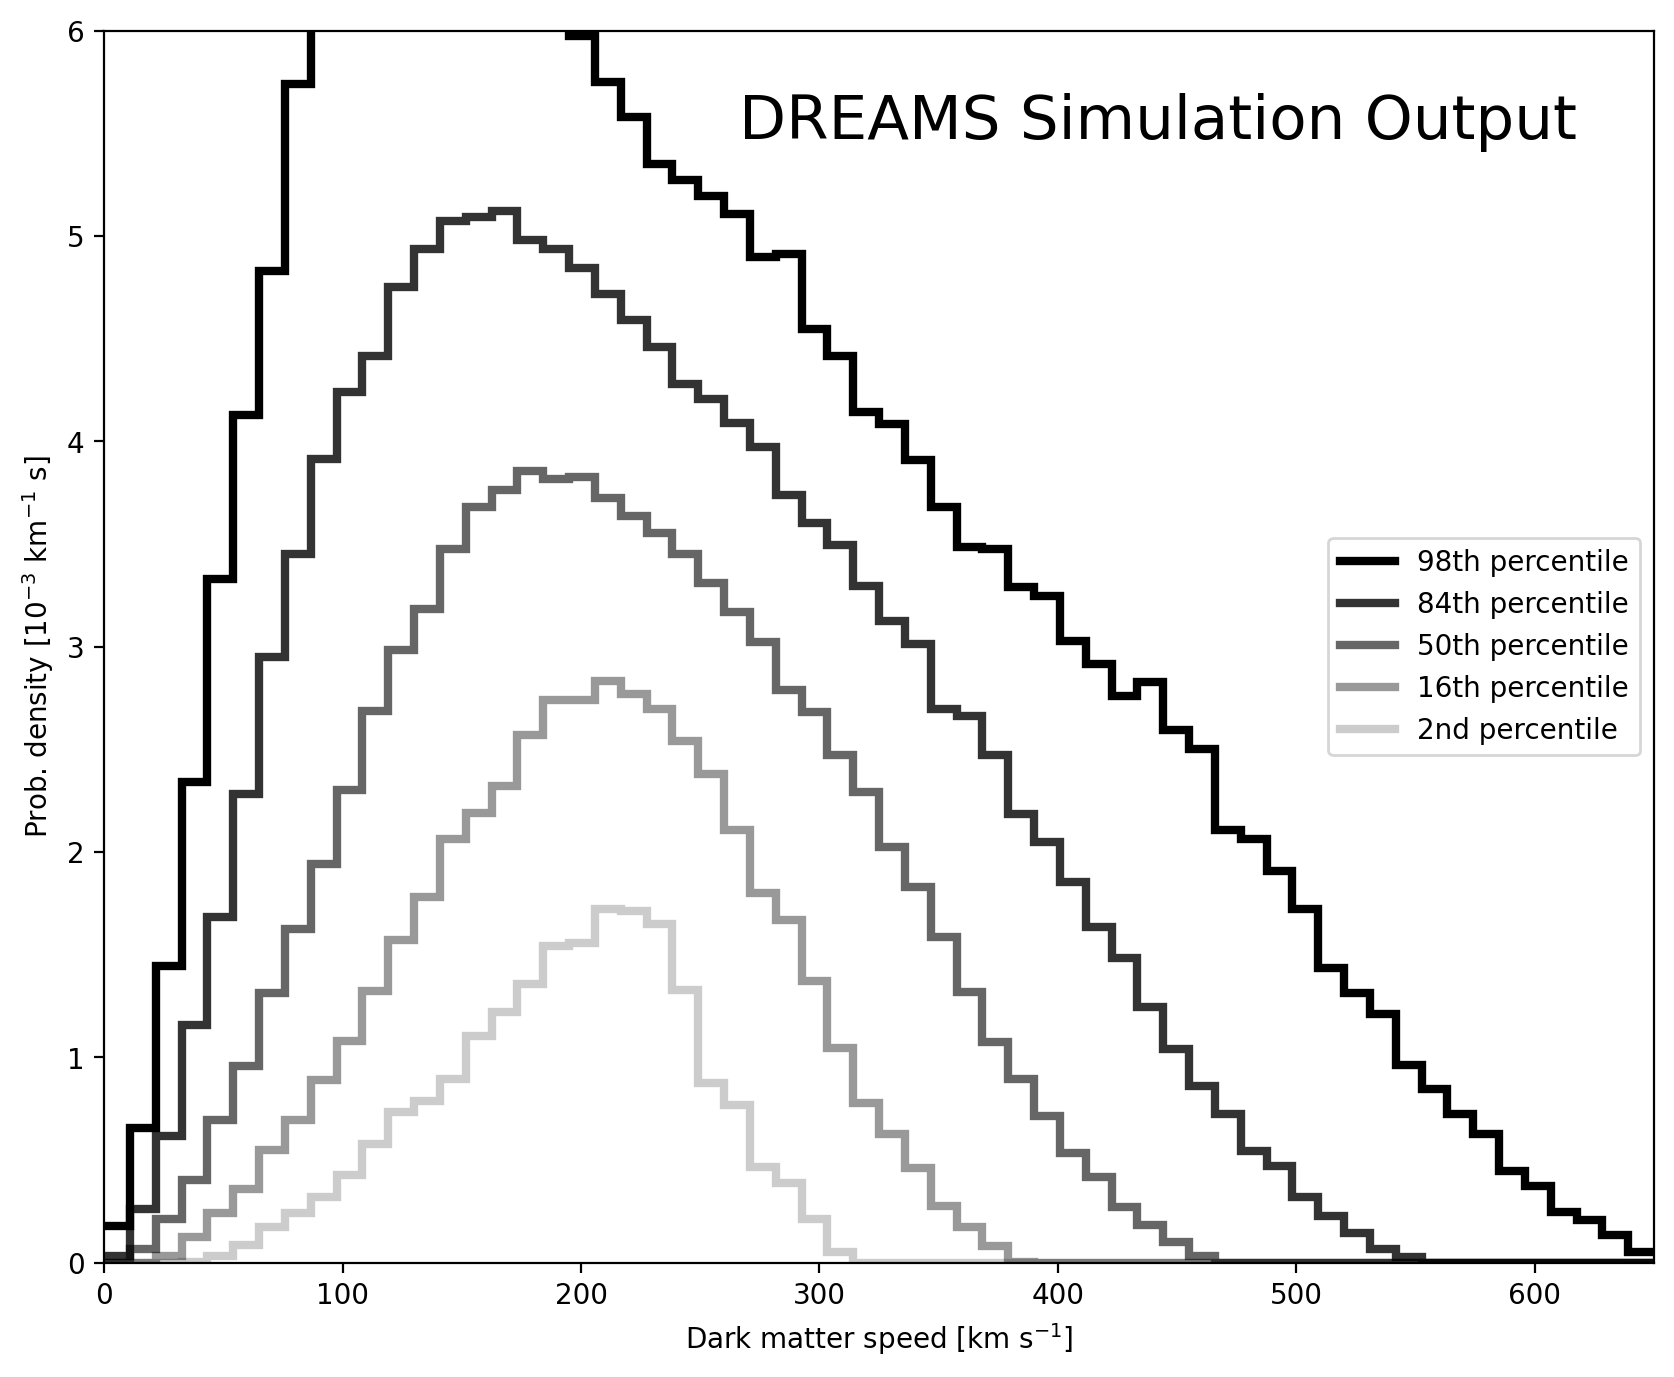

In [17]:
hists = np.array(hists)
hists1,mins,two,sixteen,eightyfour,ninetyeight,maxs = histogram_averaging(hists)

frq,edges = hists1,binpos
fig,ax=plt.subplots(dpi=200,figsize=(10,8))

ax.set_xlim(0,650)
ax.set_ylim(0,.006*1E3)
plt.stairs(ninetyeight*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=1,baseline=None,label='98th percentile')
plt.stairs(eightyfour*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.8,baseline=None,label='84th percentile')
plt.stairs(frq*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.6,baseline=None,label='50th percentile')#'M8kpc and Rm Binned Galaxies')
plt.stairs(sixteen*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.4,baseline=None,label='16th percentile')
plt.stairs(two*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.2,baseline=None,label='2nd percentile')
plt.text(0.95, 0.95, 'DREAMS Simulation Output', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',fontsize=22)
plt.legend()

plt.xlabel('Dark matter speed [km s$^{-1}$]')
plt.ylabel('Prob. density [$10^{-3}$ km$^{-1}$ s]')

plt.show()